# Breast Cancer Classification
Dataset : https://www.kaggle.com/paultimothymooney/breast-histopathology-images <br>

In [1]:
import os
import numpy as np
from imutils import paths
import random
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
#  Configuration
ORIG_INPUT_DATASET = "orig"
 
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "datasets"
 
# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
 
# define the amount of data that will be used training
TRAIN_SPLIT = 0.8
 
# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = 0.1

In [4]:
# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)
 
# compute the training and testing split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]
 
# we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]
 
# define the datasets that we'll be building
datasets = [
    ("training", trainPaths, TRAIN_PATH),
    ("validation", valPaths, VAL_PATH),
    ("testing", testPaths, TEST_PATH)
]

In [5]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))

    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)

    # loop over the input image paths
    for inputPath in imagePaths:
        # extract the filename of the input image and extract the
        # class label ("0" for "negative" and "1" for "positive")
        filename = inputPath.split(os.path.sep)[-1]
        label = filename[-5:-4]

        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])

        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)

        # construct the path to the destination image and then copy
        # the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating datasets/training' directory
[INFO] 'creating datasets/training/0' directory
[INFO] 'creating datasets/training/1' directory
[INFO] building 'validation' split
[INFO] 'creating datasets/validation' directory
[INFO] 'creating datasets/validation/1' directory
[INFO] 'creating datasets/validation/0' directory
[INFO] building 'testing' split
[INFO] 'creating datasets/testing' directory
[INFO] 'creating datasets/testing/0' directory
[INFO] 'creating datasets/testing/1' directory


In [ ]:
# directory=os.listdir('datasets/testing/1')
# for each in directory:
#     plt.figure()
#     currentFolder = "dataset/" + each + "/"
#     print(currentFolder)
#     plt.figure(figsize=(15,10))
#     for i, file in enumerate(os.listdir(currentFolder)[0:5]):
#         fullpath = currentFolder + file
#         img=mpimg.imread(fullpath)
#         plt.subplot(2, 5, i+1)
#         plt.imshow(img)

In [10]:
def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 2
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 3
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [12]:
# initialize our number of epochs, initial learning rate, and batch
# size
NUM_EPOCHS = 40
INIT_LR = 1e-2
BS = 32
 
# determine the total number of image paths in training, validation,
# and testing directories
trainPaths = list(paths.list_images(TRAIN_PATH))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))
 
# account for skew in the labeled data
trainLabels = [int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels = np_utils.to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [13]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [14]:
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=True,
    batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
    VAL_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS)

Found 255971 images belonging to 2 classes.
Found 42611 images belonging to 2 classes.
Found 99967 images belonging to 2 classes.


In [15]:
checkpoint = ModelCheckpoint("weights{epoch:03d}.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
from datetime import datetime
start = datetime.now()
callbacks = [checkpoint]
model = build(width=48, height=48, depth=3,
    classes=2)
opt = Adagrad(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# fit the model
H = model.fit_generator(
    trainGen,
    steps_per_epoch=32,
    validation_data=valGen,
    validation_steps=32,
    class_weight=classWeight,
    epochs=NUM_EPOCHS,
    callbacks=callbacks
)
print(datetime.now() - start)

W1029 14:38:36.639047 140620825626368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1029 14:38:36.868456 140620825626368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1029 14:38:36.974891 140620825626368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1029 14:38:37.321937 140620825626368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1029 14:38:37.323072 1406208256

Epoch 1/40
32/32 [==============================] - 32s 987ms/step - loss: 0.8731 - acc: 0.6816 - val_loss: 0.7313 - val_acc: 0.6748

Epoch 00001: val_acc improved from -inf to 0.67480, saving model to weights001.h5
Epoch 2/40
32/32 [==============================] - 23s 726ms/step - loss: 0.6496 - acc: 0.7236 - val_loss: 0.2460 - val_acc: 0.8936

Epoch 00002: val_acc improved from 0.67480 to 0.89355, saving model to weights002.h5
Epoch 3/40
32/32 [==============================] - 21s 666ms/step - loss: 0.5946 - acc: 0.7686 - val_loss: 0.5711 - val_acc: 0.6699

Epoch 00003: val_acc did not improve from 0.89355
Epoch 4/40
32/32 [==============================] - 20s 615ms/step - loss: 0.5315 - acc: 0.7627 - val_loss: 0.2015 - val_acc: 0.8984

Epoch 00004: val_acc improved from 0.89355 to 0.89844, saving model to weights004.h5
Epoch 5/40
32/32 [==============================] - 25s 783ms/step - loss: 0.5416 - acc: 0.7627 - val_loss: 0.1166 - val_acc: 0.9590

Epoch 00005: val_acc improve

In [24]:
from keras.models import load_model
a = load_model("weights035.h5")

In [28]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = a.predict_generator(testGen,steps=(totalTest // BS) + 1)
 
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
 
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.15      0.25     71652
           1       0.32      0.99      0.48     28315

    accuracy                           0.39     99967
   macro avg       0.65      0.57      0.37     99967
weighted avg       0.80      0.39      0.32     99967



In [30]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
    steps=(totalTest // BS) + 1)
 
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
 
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     71652
           1       0.67      0.74      0.71     28315

    accuracy                           0.83     99967
   macro avg       0.78      0.80      0.79     99967
weighted avg       0.83      0.83      0.83     99967



[[61461 10191]
 [ 7283 21032]]
acc: 0.8252
sensitivity: 0.8578
specificity: 0.7428


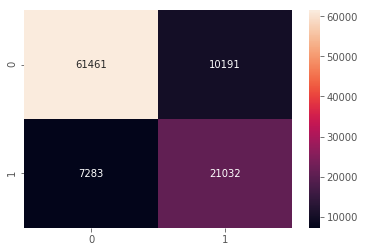

In [33]:
cm = confusion_matrix(testGen.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
 
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
sns.heatmap(cm, annot=True, fmt='g')

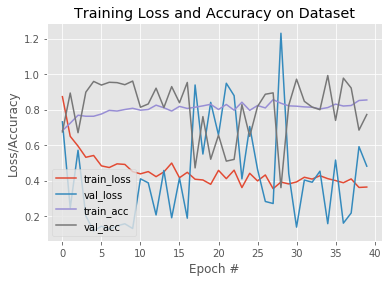

In [32]:
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")